In [8]:
# some_file.py
#import sys
# insert at 1, 0 is the script path (or '' in REPL)
#sys.path.insert(1, '/Users/leon/Files/dscribe')
import dscribe
#import dscribe.descriptors
#sys.path.insert(1, '/Users/leon/Files/dscribe/decriptors')
from dscribe.descriptors import SOAP
from dscribe.descriptors import ACSF

In [20]:
import numpy as np
import os
from tqdm import tqdm

from ase.io import read
from ase.build import molecule
from ase import Atoms
from ase.visualize import view
import math
import sklearn
#import shap

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
import numpy as np
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Adam
import matplotlib.pyplot as plt
from collections import namedtuple


In [10]:
%ls

Dscribe Encode.ipynb    __pycache__/            feature_generation/
Invariance.ipynb        batch_job_submitter.sh  model.png
Untitled.ipynb          encode_data.py          soap_parameter_test.py


In [11]:
import csv

barriers = dict()

with open('../data/vaskas_features_properties_smiles_filenames.csv', 'r') as file:
    reader = csv.reader(file)
    next(reader)
    for row in reader:
        #images.append(row[0])
        #elos.append(row[1])
        barriers[row[93]] = float(row[91])

In [12]:
labels = []
elems = []
for f in tqdm(os.listdir("../data/coordinates_TS/")):
    if f.endswith(".xyz"):
        elems.append(read("../data/coordinates_TS/" + f))
        labels.append(barriers[f[:-7]])

labels = np.array(labels)

from sklearn.preprocessing import StandardScaler
barrierScaler = StandardScaler()
barrierScaler.fit(labels.reshape(-1, 1))
labels = barrierScaler.transform(labels.reshape(-1, 1))

100%|██████████| 1947/1947 [00:01<00:00, 1013.15it/s]


In [13]:
print(len(elems))

1947


In [14]:
species = ["H", "C", "O", "N", "Ir", "As", "S", "P", "Br", "Cl", "F", "I"]
#species = ["H"]
print(len(species))
rcut = 10.0
nmax = 1
lmax = 0

# Setting up the SOAP descriptor
soap = dscribe.descriptors.SOAP(
    species=species,
    periodic=False,
    rcut=rcut,
    nmax=nmax,
    lmax=lmax,
    rbf="polynomial"
)

print(soap.get_number_of_features())

12
Using custom library
78


In [15]:
atom_index = [[0]] * len(elems)

features_soap = soap.create(elems, positions=atom_index)

In [16]:
atom_index = [[0]] * len(elems)

features_soap = soap.create(elems[0], positions=atom_index[0])
features_soap.shape

Creating single


(1, 78)

In [17]:
acsf = ACSF(
    species=["H", "C", "O", "N", "Ir", "As", "S", "P", "Br", "Cl", "F", "I"],
    rcut=6.0,
    g2_params=[[1, 1], [1, 2], [1, 3]],
    g4_params=[[1, 1, 1], [1, 2, 1], [1, 1, -1], [1, 2, -1]],
)

In [18]:
features_acsf = acsf.create(elems, positions=atom_index)

In [19]:
print(features_acsf.shape)

Atoms(symbols='IrH2NC2NC2H4C3H2CH3CH3N2CNHNCS', pbc=False)


In [20]:
#features_cnn = []
#for x in range(len(features_acsf)):
#    features_cnn.append(np.concatenate((features_soap[x], features_acsf[x])))
    
#features_cnn = np.array(features_cnn)

features_cnn = features_soap

In [21]:
from sklearn.preprocessing import StandardScaler
inputScaler = StandardScaler()
inputScaler.fit(features_cnn)
features_cnn = inputScaler.transform(features_cnn)

In [22]:
print(elems[0])
view(elems[0], viewer='x3d')

In [23]:
IndexTouple = namedtuple('IndexTouple', ['center', 'species1', 'species2', 'l', 'n1', 'n2'])

indices = []

centers = 1
for Hs in range(centers):
    for Z1 in range(len(species)):
        for Z2 in range(Z1, len(species)):
            if Z1 == Z2:
                for l in range(lmax+1):
                    for N1 in range(nmax):
                        for N2 in range(N1, nmax):
                            indices.append(IndexTouple(Hs, Z1, Z2, l,N1,N2))
            else:
                for l in range(lmax+1):
                    for N1 in range(nmax):
                        for N2 in range(nmax):
                            indices.append(IndexTouple(Hs, Z1, Z2, l,N1,N2))

print(len(indices))
print(indices)

Atom('Ir', [-0.189433, -0.19121, -0.389123], index=0)

In [24]:
# These locations can be directly used to slice the corresponding part from an
# SOAP output for e.g. plotting.
print(features_soap[0, soap.get_location(("H", "H"))])
print(np.array(indices[soap.get_location(("H", "H"))]))
#print(features_soap)

[577.62055255]
[[0 0 0 0 0 0]]


21.883905861631103


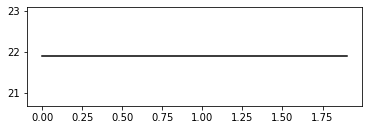

In [25]:
def gaus_basis(r, a):
    return np.exp(-((a * r)**2))

pair = ('H', 'S')

r = np.arange(0, 2, 0.1)

plt.figure()
plt.subplot(211)
for touple in indices[soap.get_location(pair)]:
    print(features_soap[0, soap.get_location(pair)][indices[soap.get_location(pair)].index(touple)])
    plt.plot(r, gaus_basis(r, touple.n1) * gaus_basis(r, touple.n2) * features_soap[0, soap.get_location(pair)][indices[soap.get_location(pair)].index(touple)], 'k')
plt.show()


In [42]:
features_soap.shape

(1, 78)

In [43]:
def get_c(n, l, i, features, indices):
    if i == 0:
        # TODO: Works inly with one center. Adapt for inter species analysis
        return np.sqrt(features[indices.index(IndexTouple(0, n, n, i, n, n))])
    else:
        return np.sqrt(features[indices.index(IndexTouple(0, n, n, i, n, n))] - features[indices.index(IndexTouple(0, n, n, i-1, n, n))])

In [ ]:
def get_g(r,n,l):
    re

In [44]:
print(features_soap[0, soap.get_location(("H", "H"))])
print(np.array(indices[soap.get_location(("H", "H"))]))

print(get_c(0,0,0,features_soap[0, soap.get_location(("H", "H"))], indices[soap.get_location(("H", "H"))]))

[577.62055255]
[[0 0 0 0 0 0]]
24.033737798213075


In [ ]:
view(elems[2], viewer='x3d')

In [ ]:
print(features_soap[2])

In [ ]:
def gauss_orbital(r,n,l,nmax):
    sum = 0
    for n_c in range(1,nmax):
        

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.special import sph_harm

import plotly.graph_objects as go
from plotly.subplots import make_subplots

phi = np.linspace(0, np.pi, 100)
theta = np.linspace(0, 2*np.pi, 100)
phi, theta = np.meshgrid(phi, theta)

# The Cartesian coordinates of the unit sphere
x = np.sin(phi) * np.cos(theta)
y = np.sin(phi) * np.sin(theta)
z = np.cos(phi)

fig = make_subplots(rows=3, cols=3,
                    specs=[[{'is_3d': True},{'is_3d': True},{'is_3d': True}],[{'is_3d': True},{'is_3d': True},{'is_3d': True}],[{'is_3d': True},{'is_3d': True},{'is_3d': True}]],
                    subplot_titles=['Color corresponds to z', 'Color corresponds to distance to origin'],)

for l in range(3):              
    for m in range(3):
        # Calculate the spherical harmonic Y(l,m) and normalize to [0,1]
        fcolors = sph_harm(m, l, theta, phi).real
        fmax, fmin = fcolors.max(), fcolors.min()
        fcolors = (fcolors - fmin)/(fmax - fmin)


        fig.add_trace(go.Surface(x=x, y=y, z=z, surfacecolor=fcolors), l+1, m+1)

fig.update_layout(title_text="Ring cyclide")
fig.show()


In [ ]:
acsf = ACSF(
    species=["H", "C", "O", "N", "Ir", "As", "S", "P", "Br", "Cl", "F", "I"],
    rcut=6.0,
    g2_params=[[1, 1], [1, 2], [1, 3]],
    g4_params=[[1, 1, 1], [1, 2, 1], [1, 1, -1], [1, 2, -1]],
)

In [ ]:
features_acsf = acsf.create(elems, positions=atom_index)

In [ ]:
print(features_acsf.shape)

In [ ]:
#features_cnn = []
#for x in range(len(features_acsf)):
#    features_cnn.append(np.concatenate((features_soap[x], features_acsf[x])))
    
#features_cnn = np.array(features_cnn)

features_cnn = features_soap

In [ ]:
from sklearn.preprocessing import StandardScaler
inputScaler = StandardScaler()
inputScaler.fit(features_cnn)
features_cnn = inputScaler.transform(features_cnn)

In [ ]:
elems[85][0]

In [ ]:
print(features_cnn.shape)
print(labels.shape)

In [ ]:
import matplotlib.pyplot as plt

plt.hist(labels, bins = 20)
plt.show()

print(np.mean(labels))

In [26]:
def reg_stats(y_true,y_pred,scaler=None):
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)
  if scaler:
    y_true_unscaled = scaler.inverse_transform(y_true)
    y_pred_unscaled = scaler.inverse_transform(y_pred)
  r2 = sklearn.metrics.r2_score(y_true,y_pred)
  mae = sklearn.metrics.mean_absolute_error(y_true_unscaled, y_pred_unscaled)
  return r2,mae

In [27]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 0.5])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  plt.show()

In [28]:
(trainX_cnn, testX_cnn, trainY, testY) = train_test_split(features_cnn, labels, test_size=0.2, random_state=32)

In [29]:
inputs = tf.keras.Input(shape=(features_cnn.shape[1],))

x = tf.keras.layers.Dense(400, activation="relu", kernel_regularizer=regularizers.l2(0.005))(inputs)
x = tf.keras.layers.Dropout(0.45)(x)

x = tf.keras.layers.Dense(220, activation="relu", kernel_regularizer=regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.3)(x)

x = tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.02))(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.02))(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Dense(1, kernel_regularizer='l2')(x)

model_full = tf.keras.Model(inputs=inputs, outputs=x)


In [30]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
#opt = keras.optimizers.RMSprop(learning_rate=0.0001)
#opt = keras.optimizers.SGD(learning_rate=0.0001, momentum=0.0)
model_full.compile(loss="mean_squared_error", optimizer=opt)

def step_decay(epoch):
   initial_lrate = 0.001
   drop = 0.6
   epochs_drop = 80.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   #print(lrate)
   return lrate

In [31]:
H = model_full.fit(x=trainX_cnn, y=trainY, validation_data=(testX_cnn, testY), epochs=800, batch_size=200, verbose=2, callbacks = [tf.keras.callbacks.LearningRateScheduler(step_decay)])


Epoch 1/800
8/8 - 0s - loss: 13.1129 - val_loss: 11.8747
Epoch 2/800
8/8 - 0s - loss: 11.9424 - val_loss: 11.7449
Epoch 3/800
8/8 - 0s - loss: 11.3213 - val_loss: 11.1899
Epoch 4/800
8/8 - 0s - loss: 10.8326 - val_loss: 10.5377
Epoch 5/800
8/8 - 0s - loss: 10.4152 - val_loss: 10.0911
Epoch 6/800
8/8 - 0s - loss: 10.1059 - val_loss: 9.7608
Epoch 7/800
8/8 - 0s - loss: 9.7220 - val_loss: 9.3731
Epoch 8/800
8/8 - 0s - loss: 9.3863 - val_loss: 9.0629
Epoch 9/800
8/8 - 0s - loss: 9.0324 - val_loss: 8.7011
Epoch 10/800
8/8 - 0s - loss: 8.6848 - val_loss: 8.3298
Epoch 11/800
8/8 - 0s - loss: 8.4125 - val_loss: 8.0260
Epoch 12/800
8/8 - 0s - loss: 8.0553 - val_loss: 7.7408
Epoch 13/800
8/8 - 0s - loss: 7.7488 - val_loss: 7.4486
Epoch 14/800
8/8 - 0s - loss: 7.4842 - val_loss: 7.1657
Epoch 15/800
8/8 - 0s - loss: 7.1562 - val_loss: 6.8860
Epoch 16/800
8/8 - 0s - loss: 6.8902 - val_loss: 6.6192
Epoch 17/800
8/8 - 0s - loss: 6.6232 - val_loss: 6.3484
Epoch 18/800
8/8 - 0s - loss: 6.3521 - val_los

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3996)]            0         
_________________________________________________________________
dense (Dense)                (None, 400)               1598800   
_________________________________________________________________
dropout (Dropout)            (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 220)               88220     
_________________________________________________________________
dropout_1 (Dropout)          (None, 220)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               28288     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

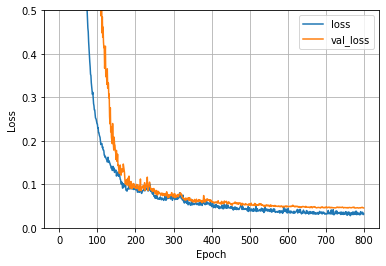

In [32]:
model_full.summary()
tf.keras.utils.plot_model(model_full)
#plot_loss(H)

R^2 Train: 0.9984223497959088
MAE Train: 0.12447393915939577

R^2 Test: 0.9702771706330866
MAE Test: 0.4841726562304374


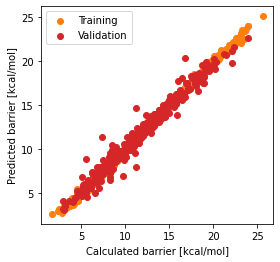

In [33]:
print("R^2 Train: " + str(reg_stats(trainY, model_full.predict(trainX_cnn), barrierScaler)[0]))
print("MAE Train: " + str(reg_stats(trainY, model_full.predict(trainX_cnn), barrierScaler)[1]))
print("")
print("R^2 Test: " + str(reg_stats(testY, model_full.predict(testX_cnn), barrierScaler)[0]))
print("MAE Test: " + str(reg_stats(testY, model_full.predict(testX_cnn), barrierScaler)[1]))

train_y_pred = barrierScaler.inverse_transform(model_full.predict(trainX_cnn))
train_y_real = barrierScaler.inverse_transform(trainY)

test_y_pred = barrierScaler.inverse_transform(model_full.predict(testX_cnn))
test_y_real = barrierScaler.inverse_transform(testY)


fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(train_y_real, train_y_pred, marker="o", c="C1", label="Training")
ax.scatter(test_y_real, test_y_pred, marker="o", c="C3", label="Validation")
ax.set_aspect('equal')
ax.set_xlabel("Calculated barrier [kcal/mol]")
ax.set_ylabel("Predicted barrier [kcal/mol]")
ax.legend(loc="upper left")

plt.show()

In [34]:
shap.initjs()

keras is no longer supported, please use tf.keras instead.


Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


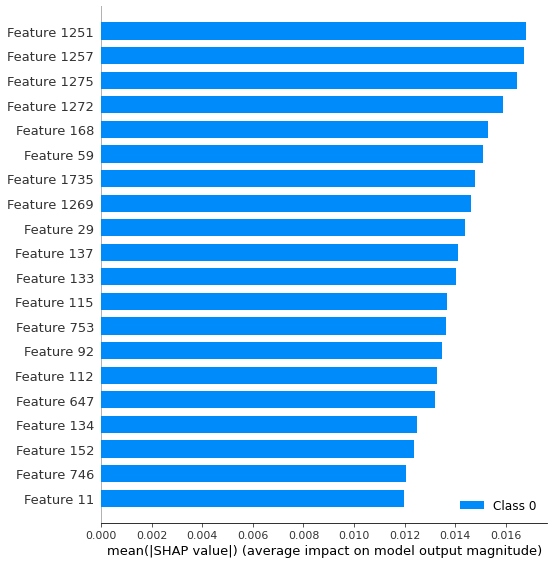

In [35]:
shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough

explainer = shap.DeepExplainer(model_full, trainX_cnn[:100])
shap_values = explainer.shap_values(testX_cnn[:100])
shap.summary_plot(shap_values, testX_cnn, plot_type='bar')

In [36]:
def f(X):
    return model_full.predict(X).flatten()

feature_no = 23
explainer = shap.KernelExplainer(f, testX_cnn[:20])
shap_values = explainer.shap_values(testX_cnn[feature_no:(feature_no+1)], nsamples=500)
shap.force_plot(explainer.expected_value, shap_values, testX_cnn[feature_no:(feature_no+1)])